# the  code
- to change what ATR/volatility to track you have to change the first arg in the 3rd cell
- higher ATR means more volatility at a given time

In [16]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime, timedelta

In [17]:
engine = create_engine('sqlite:///Intraday_Stock_Price_DB.db')

In [18]:
endTime = pd.to_datetime('now')
startTime = endTime - timedelta(days = 6, minutes = 1440)

# using BTC right now because not a trading day for stocks at the time of creating this (sunday)
data = yf.download('BTC-USD', start = startTime, end = endTime, interval = '1m')

[*********************100%***********************]  1 of 1 completed


In [19]:
if data.empty:
    raise ValueError("No data retrieved. Check the ticker for the stock/crypto or check the time range")

In [20]:
print(data.head())

                                   Open          High           Low  \
Datetime                                                              
2024-09-08 19:02:00+00:00  54424.839844  54424.839844  54424.839844   
2024-09-08 19:03:00+00:00  54417.980469  54417.980469  54417.980469   
2024-09-08 19:04:00+00:00  54459.621094  54459.621094  54459.621094   
2024-09-08 19:05:00+00:00  54450.703125  54450.703125  54450.703125   
2024-09-08 19:06:00+00:00  54461.359375  54461.359375  54461.359375   

                                  Close     Adj Close  Volume  
Datetime                                                       
2024-09-08 19:02:00+00:00  54424.839844  54424.839844       0  
2024-09-08 19:03:00+00:00  54417.980469  54417.980469       0  
2024-09-08 19:04:00+00:00  54459.621094  54459.621094       0  
2024-09-08 19:05:00+00:00  54450.703125  54450.703125       0  
2024-09-08 19:06:00+00:00  54461.359375  54461.359375       0  


In [21]:
tableInfo = pd.read_sql("PRAGMA tableInfo(BTCUSD_1m);", engine)
print(tableInfo)

    cid       name       type  notnull dflt_value  pk
0     0       Date  TIMESTAMP        0       None   0
1     1       Open      FLOAT        0       None   0
2     2       High      FLOAT        0       None   0
3     3        Low      FLOAT        0       None   0
4     4      Close      FLOAT        0       None   0
5     5  Adj Close      FLOAT        0       None   0
6     6     Volume     BIGINT        0       None   0
7     7    highLow      FLOAT        0       None   0
8     8  highClose      FLOAT        0       None   0
9     9   lowClose      FLOAT        0       None   0
10   10         TR      FLOAT        0       None   0
11   11        ATR      FLOAT        0       None   0


In [31]:
requiredColumns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
existingColumns = tableInfo['name'].tolist()
if not all(col in existingColumns for col in requiredColumns):
    raise ValueError("Required columns are missing from the database schema !")

In [23]:
try:
    maxDate = pd.read_sql('SELECT MAX(Date) FROM BTCUSD_1m', engine).values[0][0]
except Exception as e:
    print(f"Error fetching maxDate: {e}")
    maxDate = None

In [ ]:
if maxDate is not None:
    newRows = data[data.index > pd.to_datetime(maxDate)]
else:
    print("maxDate is null, prolly no data in the database")
    newRows = data.copy()

In [25]:
newRows['highLow'] = newRows['High'] - newRows['Low']
newRows['highClose'] = (newRows['High'] - newRows['Close'].shift()).abs()
newRows['lowClose'] = (newRows['Low'] - newRows['Close'].shift()).abs()

In [26]:
newRows['TR'] = newRows[['highLow', 'highClose', 'lowClose']].max(axis = 1)
newRows['ATR'] = newRows['TR'].rolling(window = 14).mean()

In [28]:
print(newRows.tail())

                                   Open          High           Low  \
Datetime                                                              
2024-09-15 18:54:00+00:00  60060.074219  60060.074219  60060.074219   
2024-09-15 18:55:00+00:00  60107.152344  60107.152344  60107.152344   
2024-09-15 18:56:00+00:00  60007.738281  60007.738281  60007.738281   
2024-09-15 18:57:00+00:00  60012.722656  60012.722656  60012.722656   
2024-09-15 18:58:00+00:00  60009.886719  60009.886719  60009.886719   

                                  Close     Adj Close    Volume  highLow  \
Datetime                                                                   
2024-09-15 18:54:00+00:00  60060.074219  60060.074219   6028288      0.0   
2024-09-15 18:55:00+00:00  60107.152344  60107.152344  37720064      0.0   
2024-09-15 18:56:00+00:00  60007.738281  60007.738281  85989376      0.0   
2024-09-15 18:57:00+00:00  60012.722656  60012.722656  38236160      0.0   
2024-09-15 18:58:00+00:00  60009.886719  60009

In [29]:
if not newRows.empty:
    try:
        newRows.to_sql('BTCUSD_1m', engine, if_exists = 'append', index_label = 'Date')
        print(f"{len(newRows)} rows have been added :)")
    except Exception as e:
        print(f"Error inserting data into database :( : {e}")

9278 rows have been added :)


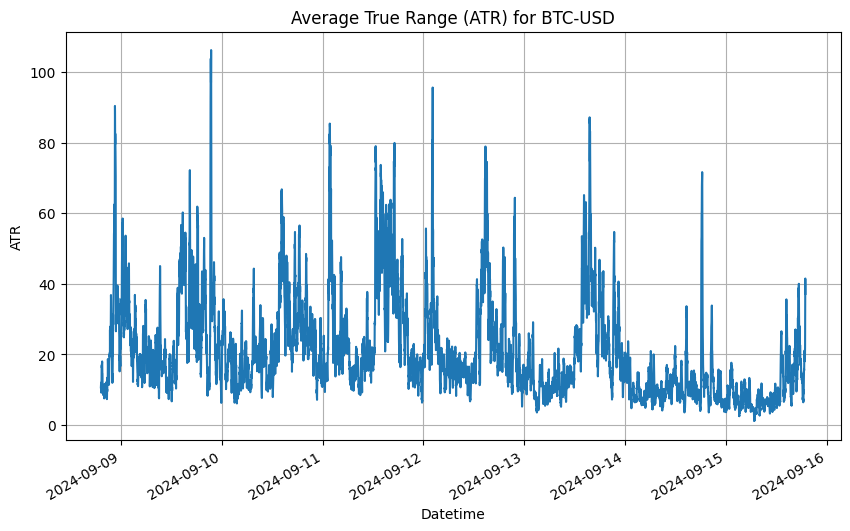

In [30]:
if 'ATR' in newRows.columns:
    newRows['ATR'].plot(figsize=(10, 6), title = 'Average True Range (ATR) for BTC-USD')
    plt.xlabel('Datetime')
    plt.ylabel('ATR')
    plt.grid(True)
    plt.show()
else:
    print("ATR column not found in newRows DataFrame :(")